# 0. Khởi tạo các đường dẫn

In [1]:
import os

# Create project directories
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "data")
MODEL_DIR = os.path.join(BASE_DIR, "models")
PLOTS_DIR = os.path.join(BASE_DIR, "plots")

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

print(f"Project directories created:")
print(f"- Data dir: {DATA_DIR}")
print(f"- Model dir: {MODEL_DIR}")
print(f"- Plots dir: {PLOTS_DIR}")

Project directories created:
- Data dir: c:\Users\tontide1\Desktop\ML_ML\data
- Model dir: c:\Users\tontide1\Desktop\ML_ML\models
- Plots dir: c:\Users\tontide1\Desktop\ML_ML\plots


# 1. Tải và đọc dữ liệu

In [7]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')  # Tải thư viện language model của NLTK

# Tải dữ liệu và giải nén - giữ nguyên code cũ
# !wget https://github.com/hoanganhpham1006/Vietnamese_Language_Model/raw/master/Train_Full.zip
# !unzip /content/Train_Full.zip

# Đọc dữ liệu - giữ nguyên code cũ
import os

full = []
# Đường dẫn đúng đến thư mục chứa dữ liệu
data_dir = os.path.join(os.getcwd(), 'data', 'Train_Full')  

if not os.path.exists(data_dir):
    print(f"Thư mục {data_dir} không tồn tại. Vui lòng kiểm tra lại đường dẫn.")
else:
    count = 0
    for dirname, _, filenames in os.walk(data_dir):
        for filename in filenames:
            try:
                file_path = os.path.join(dirname, filename)
                with open(file_path, 'r', encoding='UTF-16') as f:
                    full.append(f.read())
                count += 1
                if count % 100 == 0:
                    print(f"Đã đọc {count} files...", end="\r")
            except Exception as e:
                print(f"Lỗi khi đọc file {file_path}: {e}")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tontide1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tontide1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [8]:
import re
from nltk import word_tokenize
import string
from tqdm import tqdm

def tokenize(doc):
    tokens = word_tokenize(doc.lower())
    table = str.maketrans('', '', string.punctuation.replace("_", ""))
    tokens = [w.translate(table) for w in tokens]
    tokens = [word for word in tokens if word]
    return tokens

full_data = ". ".join(full)
full_data = full_data.replace("\n", ". ")
corpus = []
sents = re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', full_data)
for sent in tqdm(sents):
    corpus.append(tokenize(sent))

print(f"Số lượng câu: {len(corpus)}")

100%|██████████| 738597/738597 [02:04<00:00, 5943.86it/s]

Số lượng câu: 738597


# 2. Đưa văn bản về không dấu

In [9]:
import re

def remove_vn_accent(word):
    word = re.sub('[áàảãạăắằẳẵặâấầẩẫậ]', 'a', word)
    word = re.sub('[éèẻẽẹêếềểễệ]', 'e', word)
    word = re.sub('[óòỏõọôốồổỗộơớờởỡợ]', 'o', word)
    word = re.sub('[íìỉĩị]', 'i', word)
    word = re.sub('[úùủũụưứừửữự]', 'u', word)
    word = re.sub('[ýỳỷỹỵ]', 'y', word)
    word = re.sub('đ', 'd', word)
    return word

# Tải danh sách âm tiết tiếng Việt nếu chưa có
!wget -O vn_syllables.txt "https://gist.githubusercontent.com/hieuthi/0f5adb7d3f79e7fb67e0e499004bf558/raw/135a4d9716e49a981624474156d6f247b9b46f6a/all-vietnamese-syllables.txt"

def gen_accents_word(word):
    """Tạo các phiên bản có dấu khác nhau của một từ không dấu"""
    word_no_accent = remove_vn_accent(word.lower())
    all_accent_word = {word}
    for w in open('vn_syllables.txt').read().splitlines():
        w_no_accent = remove_vn_accent(w.lower())
        if w_no_accent == word_no_accent:
            all_accent_word.add(w)
    return all_accent_word

--2025-05-19 15:44:35--  https://gist.githubusercontent.com/hieuthi/0f5adb7d3f79e7fb67e0e499004bf558/raw/135a4d9716e49a981624474156d6f247b9b46f6a/all-vietnamese-syllables.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116290 (114K) [text/plain]
Saving to: 'vn_syllables.txt'

     0K .......... .......... .......... .......... .......... 44% 1.06M 0s
    50K .......... .......... .......... .......... .......... 88% 1.47M 0s
   100K .......... ...                                        100% 55.2M=0.08s

2025-05-19 15:44:36 (1.40 MB/s) - 'vn_syllables.txt' saved [116290/116290]



# 4. Train và lưu mô hình

In [5]:
import pickle
import math
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import KneserNeyInterpolated
from tqdm import tqdm

# Tạo mô hình ngôn ngữ sử dụng NLTK
print("Tạo mô hình trigram NLTK...")

# Chuẩn bị dữ liệu cho mô hình ngôn ngữ
n = 3  # Trigram model
train_data, padded_vocab = padded_everygram_pipeline(n, corpus)

# Khởi tạo mô hình Kneser-Ney
model = KneserNeyInterpolated(n)

# Huấn luyện mô hình
print("Bắt đầu huấn luyện mô hình...")
model.fit(train_data, padded_vocab)
print(f"Hoàn thành huấn luyện. Kích thước từ điển: {len(model.vocab)}")

# Lưu mô hình bằng pickle
model_path = "nltk_trigram_model.pkl"
with open(model_path, 'wb') as fout:
    pickle.dump(model, fout)
print(f"Đã lưu mô hình vào {model_path}")

Tạo mô hình trigram NLTK...
Bắt đầu huấn luyện mô hình...
Hoàn thành huấn luyện. Kích thước từ điển: 104813
Đã lưu mô hình vào nltk_trigram_model.pkl


# 5. Thuật toán beam search

In [34]:
def beam_search_nltk(words, model, k=3):
    """
    Sử dụng Beam Search để tìm chuỗi từ có dấu với điểm số cao nhất
    sử dụng mô hình NLTK

    Args:
        words: Danh sách các từ không dấu
        model: Mô hình ngôn ngữ NLTK
        k: Số lượng lựa chọn tốt nhất giữ lại ở mỗi bước
    """
    sequences = []

    for idx, word in enumerate(words):
        if idx == 0:
            # Bước đầu tiên - tạo các phiên bản có dấu của từ đầu tiên
            sequences = [([x], 0.0) for x in gen_accents_word(word)]
        else:
            all_sequences = []

            for seq in sequences:
                # Với mỗi chuỗi hiện tại, thử tất cả các phiên bản có dấu của từ tiếp theo
                for next_word in gen_accents_word(word):
                    score = 0

                    # Lấy context tối đa 2 từ trước đó cho trigram model
                    context = seq[0][-min(2, len(seq[0])):]

                    # Tính điểm sử dụng logscore của mô hình NLTK
                    try:
                        score = model.logscore(next_word, context)
                    except (ValueError, KeyError):
                        # Xử lý trường hợp context không có trong mô hình
                        # Gán giá trị xác suất rất nhỏ
                        score = -100

                    # Tạo chuỗi mới và cập nhật điểm
                    new_seq = seq[0].copy()
                    new_seq.append(next_word)
                    all_sequences.append((new_seq, seq[1] + score))

            # Giữ lại k chuỗi có điểm cao nhất
            all_sequences = sorted(all_sequences, key=lambda x: x[1], reverse=True)
            sequences = all_sequences[:k]

    return sequences

# 6. Test mô hình

In [ ]:
from nltk.tokenize.treebank import TreebankWordDetokenizer
import pickle

detokenize = TreebankWordDetokenizer().detokenize

# Tải mô hình đã huấn luyện
with open("nltk_trigram_model.pkl", 'rb') as fin:
    nltk_model = pickle.load(fin)

# Thử nghiệm thêm dấu
test_sentences = [
    "toi la nguoi viet nam",
    "hom nay toi di hoc",
    "ngay hom qua la ngay bau cu tong thong My",
    "tieng viet la ngon ngu cua nguoi viet"
]

for sentence in test_sentences:
    print(f"\nCâu gốc: {sentence}")
    result = beam_search_nltk(sentence.lower().split(), nltk_model, k=3)

    print("Top 3 kết quả:")
    for i, (words, score) in enumerate(result):
        print(f"{i+1}. {detokenize(words)} (score: {score:.4f})")


Câu gốc: toi la nguoi viet nam
Top 3 kết quả:
1. tôi là người việt nam (score: -14.4853)
2. toi la nguoi viet nam (score: -21.4037)
3. tôi là người việt nắm (score: -24.2213)

Câu gốc: hom nay toi di hoc
Top 3 kết quả:
1. hôm nay tôi đi học (score: -20.1828)
2. hòm này tôi đi học (score: -20.1883)
3. hôm nay tôi đi hoc (score: -23.6065)

Câu gốc: ngay hom qua la ngay bau cu tong thong My


In [14]:
from nltk.tokenize.treebank import TreebankWordDetokenizer

detokenize = TreebankWordDetokenizer().detokenize

test_sentence = "ngay hom qua la ngay bau cu tong thong My"

# Dự đoán từ mô hình
predictions = []

# Chạy beam search cho câu thử nghiệm
result = beam_search_nltk(test_sentence.lower().split(), model=nltk_model, k=3)
best_sentence = detokenize(result[0][0])
predictions.append(best_sentence)

# 7. Đánh giá mô hình với 3 độ đo là accuracy, F1, error_rate

In [28]:
from nltk.metrics.distance import edit_distance

def sentence_level_accuracy(results: list[dict]) -> float:
    """
    Tính độ chính xác ở mức câu cho nhiều cặp câu
    
    Args:
        results: Danh sách các dictionary chứa cặp câu dự đoán và tham chiếu
        
    Returns:
        Tỷ lệ phần trăm số câu được dự đoán chính xác hoàn toàn
    """
    if not results:
        return 0.0
    
    correct_sentences = 0
    for res in results:
        if res["true_accented"].strip() == res["predicted_accented"].strip():
            correct_sentences += 1
            
    return (correct_sentences / len(results)) * 100

def word_level_accuracy(pred, ref):
    """
    Tính độ chính xác ở mức từ (word accuracy)
    
    Args:
        pred: Câu dự đoán
        ref: Câu tham chiếu (câu đúng)
        
    Returns:
        Tỷ lệ từ đúng trên tổng số từ trong câu tham chiếu
    """
    pred_words = pred.strip().split()
    ref_words = ref.strip().split()
    
    if not ref_words:
        return 0.0
    
    # Đếm số từ đúng (chỉ so sánh đến độ dài ngắn nhất)
    correct_words = 0
    len_min = min(len(pred_words), len(ref_words))
    
    for i in range(len_min):
        if pred_words[i] == ref_words[i]:
            correct_words += 1
    
    # Độ chính xác là số từ đúng chia cho tổng số từ trong câu tham chiếu
    return correct_words / len(ref_words)

def char_level_accuracy(pred, ref):
    """
    Tính độ chính xác ở mức ký tự (character accuracy)
    
    Args:
        pred: Câu dự đoán
        ref: Câu tham chiếu (câu đúng)
        
    Returns:
        Tỷ lệ chính xác ở mức ký tự, tính dựa trên edit distance
    """
    pred_str = pred.strip()
    ref_str = ref.strip()
    
    if not ref_str:
        return 0.0
    
    # Tính edit distance giữa chuỗi dự đoán và chuỗi tham chiếu
    dist = edit_distance(pred_str, ref_str)
    
    # Độ chính xác ký tự = 1 - (edit_distance / độ dài chuỗi tham chiếu)
    return 1.0 - (dist / len(ref_str))

def f1_score(pred, ref):
    """
    Tính F1-score ở mức từ giữa câu dự đoán và câu tham chiếu
    """
    pred_words = set(pred.strip().split())
    ref_words = set(ref.strip().split())
    if not pred_words or not ref_words:
        return 0.0
    tp = len(pred_words & ref_words)
    fp = len(pred_words - ref_words)
    fn = len(ref_words - pred_words)
    if tp == 0:
        return 0.0
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if precision + recall == 0:
        return 0.0
    return 2 * precision * recall / (precision + recall)

def character_error_rate(pred, ref):
    """
    Tính Character Error Rate (CER) giữa câu dự đoán và câu tham chiếu
    """
    pred_str = pred.strip()
    ref_str = ref.strip()
    if not ref_str:
        return 1.0
    dist = edit_distance(pred_str, ref_str)
    return dist / len(ref_str)

def word_error_rate(pred, ref):
    """
    Tính Word Error Rate (WER) giữa câu dự đoán và câu tham chiếu
    """
    pred_words = pred.strip().split()
    ref_words = ref.strip().split()
    if not ref_words:
        return 1.0
    dist = edit_distance(pred_words, ref_words)
    return dist / len(ref_words)

# 7.1 test

In [ ]:
# Ví dụ sử dụng
reference = "Ngày hôm qua là ngày bầu cử tổng thống Mỹ"
predicted = "Ngày hôm qua là ngày bầu cứ tổng thông Mỹ"

# Tính các chỉ số độ chính xác
sent_acc = sentence_level_accuracy([{"predicted_accented": predicted, "true_accented": reference}])
word_acc = word_level_accuracy(predicted, reference)
char_acc = char_level_accuracy(predicted, reference)
f1 = f1_score(predicted, reference)
cer = character_error_rate(predicted, reference)
wer = word_error_rate(predicted, reference)

# Hiển thị kết quả (đổi sang phần trăm)
print(f"Câu tham chiếu: {reference}")
print(f"Câu dự đoán   : {predicted}")
print(f"Sentence Accuracy         : {sent_acc:.2f}%")
print(f"Word Accuracy            : {word_acc * 100:.2f}%")  
print(f"Character Accuracy       : {char_acc * 100:.2f}%")
print(f"F1-Score                 : {f1 * 100:.2f}%")
print(f"Character Error Rate (CER): {cer * 100:.2f}%")
print(f"Word Error Rate (WER)     : {wer * 100:.2f}%")

Câu tham chiếu: Ngày hôm qua là ngày bầu cử tổng thống Mỹ
Câu dự đoán   : Ngày hôm qua là ngày bầu cứ tổng thông Mỹ
Sentence Accuracy         : 0.00%
Word Accuracy            : 80.00%
Character Accuracy       : 95.12%
F1-Score                 : 80.00%
Character Error Rate (CER): 4.88%
Word Error Rate (WER)     : 20.00%


# Evaluation

## Đánh giá với 300 mẫu dữ liệu trong bộ dữ liệu

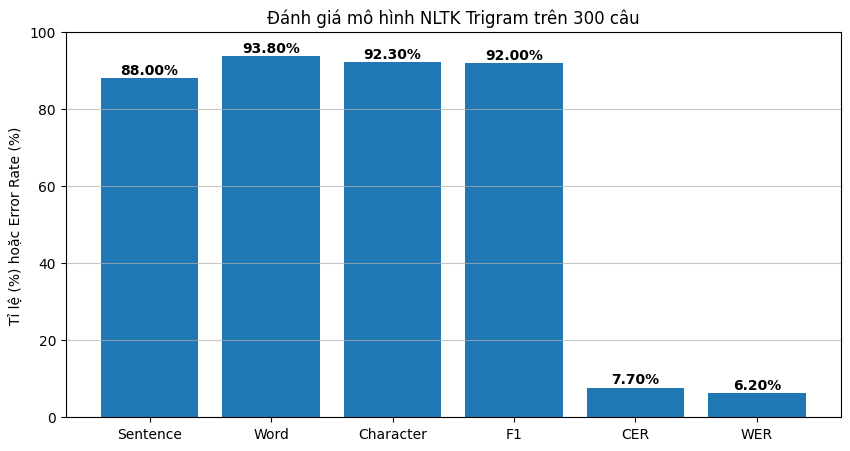

In [ ]:
import matplotlib.pyplot as plt
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.metrics.distance import edit_distance
import pickle

# Lấy 300 câu đầu tiên có dấu
sentences_with_accent = []
for para in full:
    for sent in para.split('.'):
        s = sent.strip()
        if len(s.split()) > 1:  # chỉ lấy câu đủ dài
            sentences_with_accent.append(s)
        if len(sentences_with_accent) >= 10:
            break
    if len(sentences_with_accent) >= 300:
        break

print("Số câu lấy được:", 300)
if len(sentences_with_accent) == 0:
    print("Không có câu nào đủ điều kiện trong dữ liệu!")
else:
    # Tạo câu không dấu
    sentences_no_accent = [' '.join([remove_vn_accent(w) for w in s.split()]) for s in sentences_with_accent]

    # Load mô hình
    with open('nltk_trigram_model.pkl', 'rb') as fin:
        nltk_model = pickle.load(fin)

    detokenize = TreebankWordDetokenizer().detokenize

    # Hàm beam_search_nltk đã có sẵn
    results = []
    for i in range(len(sentences_no_accent)):
        input_words = sentences_no_accent[i].split()
        beam_results = beam_search_nltk(input_words, nltk_model, k=3)
        best_sentence = detokenize(beam_results[0][0])
        results.append({
            'true_accented': sentences_with_accent[i],
            'predicted_accented': best_sentence
        })

    # Tính các chỉ số
    sent_acc = sentence_level_accuracy(results)
    word_acc = sum([word_level_accuracy(r['predicted_accented'], r['true_accented']) for r in results]) / len(results) * 100
    char_acc = sum([char_level_accuracy(r['predicted_accented'], r['true_accented']) for r in results]) / len(results) * 100
    f1 = sum([f1_score(r['predicted_accented'], r['true_accented']) for r in results]) / len(results) * 100
    cer = sum([character_error_rate(r['predicted_accented'], r['true_accented']) for r in results]) / len(results) * 100
    wer = sum([word_error_rate(r['predicted_accented'], r['true_accented']) for r in results]) / len(results) * 100


    print(f'Sentence Accuracy: {sent_acc:.2f}%')
    print(f'Word Accuracy    : {word_acc:.2f}%')
    print(f'Character Accuracy: {char_acc:.2f}%')
    print(f'F1-Score           : {f1:.2f}%')
    print(f'Character Error Rate (CER): {cer:.2f}%')
    print(f'Word Error Rate (WER)     : {wer:.2f}%')

    # Trực quan hóa
    labels = ['Sentence', 'Word', 'Character', 'F1', 'CER', 'WER']
    values = ['sent_acc', 'word_acc', 'char_acc', 'f1', 'cer', 'wer']

    plt.style.use('default')
    plt.figure(figsize=(10,5))
    # bars = plt.bar(labels, values, color=['viridis'])
    bars = plt.bar(labels, values, color=sns.color_palette("viridis", len(labels)) if 'sns' in globals() else None)
    
    plt.ylim(0, 100)
    plt.ylabel('Tỉ lệ (%) hoặc Error Rate (%)')
    plt.title('Đánh giá mô hình NLTK Trigram trên 300 câu')
    # plt.grid(axis='y', alpha=0.7)  # Thêm lưới ngang

    for i, v in enumerate(values):
        plt.text(i, v + 1, f'{v:.2f}%', ha='center', fontweight='bold')
    plt.show()



# Đánh giá trên tệp data test.txt

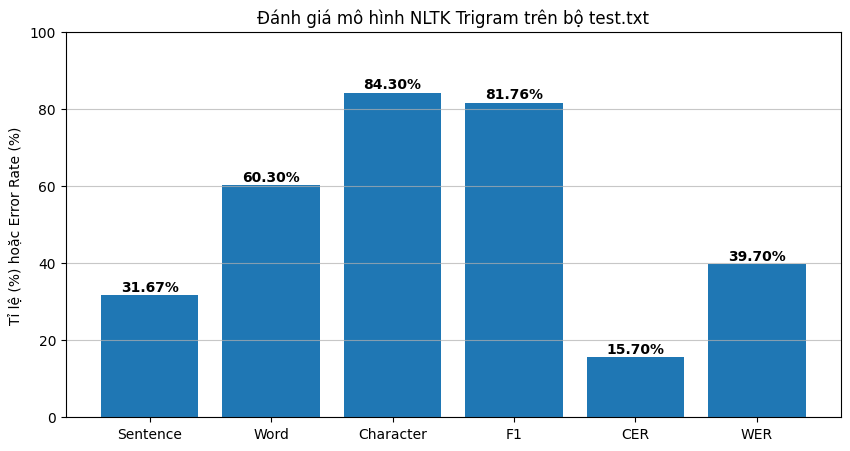

In [19]:
# Model paths
MODEL_PATH = os.path.join(MODEL_DIR, "nltk_trigram_model.pkl")
SYLLABLES_PATH = os.path.join(DATA_DIR, "vn_syllables.txt")

# Test data paths
TEST_FILE = os.path.join(BASE_DIR, "test.txt")
GROUND_TRUTH_FILE = os.path.join(BASE_DIR, "test_result.txt")

# Ensure output directories exist
os.makedirs(PLOTS_DIR, exist_ok=True)

# Create a detokenizer
_detokenizer = TreebankWordDetokenizer()

def evaluate_model_on_test_file():

    # Load the model
    model = load_model(MODEL_PATH)
    if model is None:
        print("Failed to load model. Exiting.")
        return

    # Check if test and ground truth files exist
    if not os.path.exists(TEST_FILE):
        print(f"Test file not found: {TEST_FILE}")
        return

    if not os.path.exists(GROUND_TRUTH_FILE):
        print(f"Ground truth file not found: {GROUND_TRUTH_FILE}")
        return

    # Read test data and ground truth
    try:
        with open(TEST_FILE, 'r', encoding='utf-8') as f:
            test_lines = [line.strip() for line in f.readlines() if line.strip()]

        with open(GROUND_TRUTH_FILE, 'r', encoding='utf-8') as f:
            ground_truth_lines = [line.strip() for line in f.readlines() if line.strip()]

        if len(test_lines) != len(ground_truth_lines):
            print(f"Warning: Test file has {len(test_lines)} non-empty lines, but ground truth has {len(ground_truth_lines)}.")
            print("Will evaluate only on paired lines.")
    except Exception as e:
        print(f"Error reading test files: {e}")
        return

    # Prepare for evaluation
    print(f"\nEvaluating on {min(len(test_lines), len(ground_truth_lines))} sentences...")
    evaluation_results = []

    # Process each line
    for i, (test_line, true_line) in enumerate(zip(test_lines, ground_truth_lines)):

        # Make prediction
        predictions = beam_search_nltk(test_line.lower().split(), model=model, k=3)

        predicted_text = predictions[0][0] if predictions else ""

        # Store result
        result = {
            "input_unaccented": test_line,
            "true_accented": true_line,
            "predicted_accented": predicted_text
        }
        evaluation_results.append(result)


    # Calculate metrics
    sent_accuracy = sentence_level_accuracy(evaluation_results)
    word_accuracy = word_accuracy(evaluation_results)
    char_accuracy = char_accuracy(evaluation_results)
    f1 = f1_score(evaluation_results)
    char_error_rate = character_error_rate(evaluation_results)
    word_error_rate = word_error_rate(evaluation_results)
    

    # Trực quan hóa
    labels = ['Sentence', 'Word', 'Character', 'F1', 'CER', 'WER']
    values = [sent_accuracy, word_accuracy, char_accuracy, f1, char_error_rate, word_error_rate]

    plt.style.use('default')
    plt.figure(figsize=(10,5))
    bars = plt.bar(labels, values, color=['skyblue'])
    plt.ylim(0, 100)
    plt.ylabel('Tỉ lệ (%) hoặc Error Rate (%)')
    plt.title('Đánh giá mô hình NLTK Trigram trên 300 câu')
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Thêm lưới ngang

    for i, v in enumerate(values):
        plt.text(i, v + 1, f'{v:.2f}%', ha='center', fontweight='bold')
    plt.show()

